In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import pandas as pd
import matplotlib.pyplot as plt
from ltp import LTP

d:\Users\10252\anaconda3\envs\ERC\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Emotion Recognition in Conversations

This is a Nature language Processing task. We choose to use LSTM model to solve the task. 

## Dataset
The data set we use is [CPED ](https://github.com/scutcyr/CPED), a dataset from 40 Chinese TV shows. We take "Dialogue_ID", "Utterance" ,"Emotion" from the columns for this task as shown below :

In [2]:
train = pd.read_csv("train_split.csv").loc[:,["Dialogue_ID", "Utterance" ,"Emotion"]]
display(train.head(10))

,Dialogue_ID,Utterance,Emotion
0,01_000,真巧,neutral
1,01_000,车没事了,neutral
2,01_000,是你呀 没事了没事 谢谢你,neutral
3,01_000,没事没事 你也去春风,neutral
4,01_001,对,neutral
5,01_001,你孩子也在这上学,neutral
6,01_001,对呀,neutral
7,01_002,真巧 我儿子也在这,neutral
8,01_002,你孩子几年级,neutral
9,01_002,高三了,neutral


The count of different emotions is shown in the bar chart below and we noticed that the distribution of emotions in different TV series is similar to the distribution in the whole dataset. So we can reduce the data size.

C:\Users\10252\AppData\Local\Temp\ipykernel_14824\1265799981.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


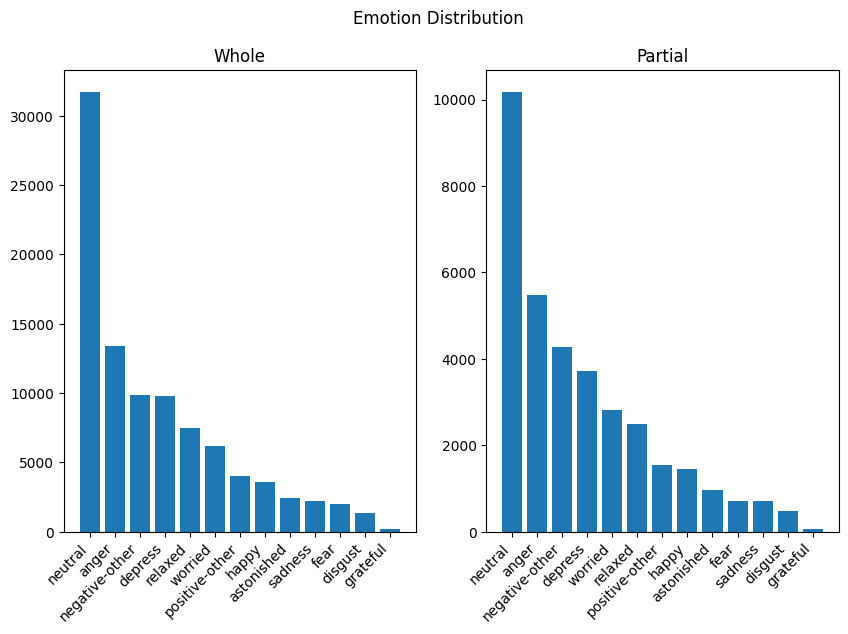

In [5]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,6))
fig.suptitle('Emotion Distribution')
count_part = train.loc[0:34877, "Emotion"].value_counts()
count_whole = train.loc[:, "Emotion"].value_counts()
ax1.bar(count_whole.index,count_whole)
ax1.set_title("Whole")
ax2.bar(count_part.index,count_part)
ax2.set_title("Partial")
for ax in ax1,ax2:
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
fig.show()

## Tokenization
As it is a dataset with Chinese characters, tokenization process cannot just split the sentence to different characters but need to combine some characters to form words. For this process we use [LTP](https://github.com/HIT-SCIR/ltp), a model aimed for Chinese tokenization. It's noteworthy that some chatacters in the speakers' names mentioned in the utterance may be combined with other characters wrongly. To aviod this we add the names into the dictionary in advance.

In [7]:
import pandas as pd
import torch
from ltp import LTP
import re
import sys

# import dataset and model
train = pd.read_csv("train_split.csv").loc[0:99,["Dialogue_ID", "Utterance" ,"Emotion"]] # Here just do tokenization on part of the dataset for display
ltp = LTP()
# ltp.to("cuda")

def process_bar(num, total):
    rate = float(float(num)/total)
    ratenum = int(100*rate)
    r = '\r[{}{}]{}% {} Lines done.'.format('*'*ratenum,' '*(100-ratenum), ratenum, num)
    sys.stdout.write(r)
    sys.stdout.flush()

train["Utterance"] = train["Utterance"].apply((lambda x: re.sub('[\s，。]','',x))) # Remove space and punctuation marks
speakers = pd.read_csv("speakers.txt", header = None)

for speaker in speakers:
    ltp.add_words(words=speaker) # Adding speakers to the dictionary

size = len(train.index)

train["Tokenization"] = ""
for i in range(len(train.index)):
    train.loc[i, "Tokenization"] = str(ltp.pipeline(train.loc[i, "Utterance"], tasks = ["cws"])["cws"])
    process_bar(i+1, size)
display(train.head(10))
train.to_csv("train_tokenized_demo.csv")

[****************************************************************************************************]100% 100 Lines done.

,Dialogue_ID,Utterance,Emotion,Tokenization
0,01_000,真巧,neutral,"['真', '巧']"
1,01_000,车没事了,neutral,"['车', '没事', '了']"
2,01_000,是你呀没事了没事谢谢你,neutral,"['是', '你', '呀', '没事', '了', '没', '事', '谢谢', '你']"
3,01_000,没事没事你也去春风,neutral,"['没', '事', '没', '事', '你', '也', '去', '春风']"
4,01_001,对,neutral,['对']
5,01_001,你孩子也在这上学,neutral,"['你', '孩子', '也', '在', '这', '上学']"
6,01_001,对呀,neutral,"['对', '呀']"
7,01_002,真巧我儿子也在这,neutral,"['真巧', '我', '儿子', '也', '在', '这']"
8,01_002,你孩子几年级,neutral,"['你', '孩子', '几', '年级']"
9,01_002,高三了,neutral,"['高', '三', '了']"


After tokenization, the distribution of the length (part of the data) is shown below :

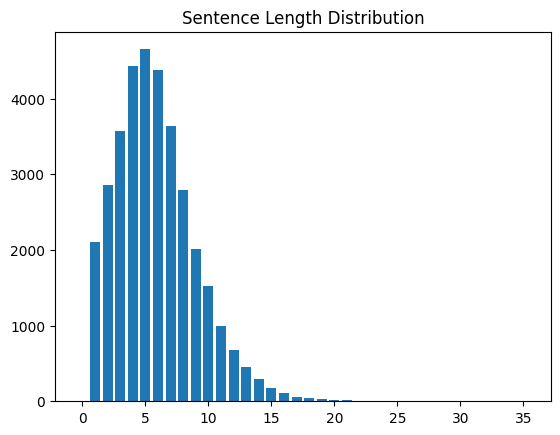

In [8]:
train = pd.read_csv("train_tokenized.csv").loc[0:34877]
train["Length"] = train["Tokenization"].apply(lambda x :len(re.sub('[\[\]\s\']','',x).split(","))) # String of tokenized list -> list
frequency = train["Length"].value_counts()
xlabels = list(range(36))
ylabels = [0]*36
for i in frequency.index:
    ylabels[i] = frequency[i]
plt.bar(xlabels, ylabels)
plt.title('Sentence Length Distribution')
plt.show()


## Word embedding
We used CBoW model to do the word embedding but the training process is quite slow. So we used pretrained Chinese word vectors (cc.zh.300.bin) from [fasttext](https://fasttext.cc/) instead. The dataset after embedding can be accessed at [Google Drive](https://drive.google.com/drive/folders/1v-xP2qUXDffQRHsD299Rb5i5V1HxTIGn?usp=share_link)

## First trail on the model

We first take these utterances as unrelated sentances to figure out their emotions separately.

### Parameters

In [9]:
hidden_size = 300
batch_size = 1
data_size = 20000

### Data reading and processing

#### Importing x
The dataset after embedding can be accessed at [Google Drive](https://drive.google.com/drive/folders/1v-xP2qUXDffQRHsD299Rb5i5V1HxTIGn?usp=share_link)

In [10]:
data = pd.read_json("tensor_word_df_ft.json")
data.loc[0:34876, "Tensor"].to_json("smallX.json")

test = data.loc[34877:35831, "Tensor"]
test.reset_index(drop=True).to_json("testX.json")

valid = data.loc[38506:39594, "Tensor"]
valid.reset_index(drop=True).to_json("validX.json")

In [11]:
import pandas as pd
import tensorflow as tf

def torch2tf(pytorch_tensor): 
    # As we decided to use PyTorch at first 
    # the output is a Torch tensor 
    # so we need to change it to Tensorflow tensor
    numpy_array = pytorch_tensor.numpy()
    tensorflow_tensor = tf.convert_to_tensor(numpy_array)
    return tensorflow_tensor

def data_processing(filename,embedding_n,padding = -1):
    dataset = pd.read_json(filename)
    max_n = 0
    n_x = dataset.shape[1]
    for t in dataset:
        n = torch.tensor(dataset[t][0]).shape[0]
        if n>max_n:
            max_n = n
    if (padding == -1):
        output = torch.zeros((n_x, max_n, embedding_n))
    else:
        output = torch.zeros((n_x, padding, embedding_n))
    for i in range(len(dataset)):
        t = torch.tensor(dataset[i][0])
        output[i, :t.shape[0], :] = t
    return output


In [12]:
X_train = data_processing("smallX.json",300) 
train_n, max_n, embedding_n = X_train.shape[0], X_train.shape[1], X_train.shape[2]
print(X_train.shape)
X_test = data_processing("testX.json",300, max_n) 
test_n= X_test.shape[0]
print(X_test.shape)
X_valid = data_processing("validX.json",300, max_n) 
print(X_valid.shape)

torch.Size([69754, 34, 300])
torch.Size([1910, 34, 300])
torch.Size([2178, 34, 300])


#### Importing y
~~There are 13 different emotions in the dataset. We label these emotions with int :~~

We first train the sentiment lable

In [13]:
train_label = pd.read_csv("train_split.csv").loc[0:34876]
test_label = pd.read_csv("train_split.csv").loc[34877:35831]
valid_label = pd.read_csv("train_split.csv").loc[38506:39594]
print(train_label["Sentiment"].value_counts())
print(test_label["Sentiment"].value_counts())
print(valid_label["Sentiment"].value_counts())
emotions = list(train_label["Sentiment"].value_counts().index)
emotion2int = dict((emotions[i], (i+1)%3) for i in range(len(emotions)))
typecount = len(emotions)
train_label["EmotionID"] = train_label["Sentiment"].apply(lambda x: emotion2int[x])
test_label["EmotionID"] = test_label["Sentiment"].apply(lambda x: emotion2int[x])
valid_label["EmotionID"] = valid_label["Sentiment"].apply(lambda x: emotion2int[x])



negative    19150
neutral     10185
positive     5542
Name: Sentiment, dtype: int64
negative    404
neutral     320
positive    231
Name: Sentiment, dtype: int64
neutral     470
negative    416
positive    203
Name: Sentiment, dtype: int64


In [14]:
Y_train = torch.Tensor(train_label["EmotionID"])
Y_test = torch.Tensor(test_label["EmotionID"].reset_index(drop=True))
Y_valid = torch.Tensor(valid_label["EmotionID"].reset_index(drop=True))


In [23]:
X_train = torch2tf(X_train)
print(X_train.shape)
Y_train = torch2tf(Y_train)
Y_train = tf.one_hot(tf.cast(Y_train, dtype=tf.uint8), depth=typecount)
print(Y_train.shape)
X_test = torch2tf(X_test)
print(X_test.shape)
Y_test = torch2tf(Y_test)
Y_test = tf.one_hot(tf.cast(Y_test, dtype=tf.uint8), depth=typecount)
print(Y_test.shape)
X_valid = torch2tf(X_valid)
print(X_valid.shape)
Y_valid = torch2tf(Y_valid)
Y_valid = tf.one_hot(tf.cast(Y_valid, dtype=tf.uint8), depth=typecount)
print(Y_valid.shape)


(69754, 34, 300)
(34877, 3, 3)
(1910, 34, 300)
(955, 3, 3)
(2178, 34, 300)
tf.Tensor(
[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]], shape=(1089, 3), dtype=float32)
(1089, 3, 3)


### Model building

In [16]:
import tensorflow as tf

if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")

GPU is not available


In [17]:
import keras
from keras.layers import LSTM, Dense, Activation, Masking, TimeDistributed, Bidirectional
from keras.models import Sequential
from keras.utils import plot_model

In [18]:
h_n = embedding_n
epochs = 100
callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
    keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0,
)
]

In [19]:
def make_model(input_shape, h_n=300, num_classes=13):
    inputs = keras.Input(shape=input_shape, name="Input_layer")
    masked = Masking(0,name="Shapeshifter")(inputs)
    tmp = LSTM(500, dropout=0.6,  name="LSTM_layer", activation="tanh")(masked)
    # tmp1 = Dense(300, activation="softmax", name="Hidden_layer")(tmp)
    outputs = Dense(num_classes, activation="softmax",kernel_initializer="he_normal" ,name="Output_layer")(tmp)
    return keras.Model(inputs, outputs)

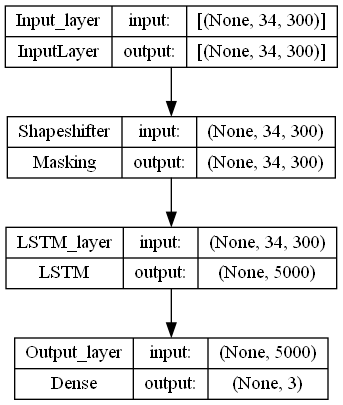

In [20]:
model = make_model(input_shape=(34,300), num_classes=typecount)
plot_model(model, show_shapes=True)

In [21]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.1),
    loss="categorical_crossentropy", 
    metrics=["accuracy"]
)

In [22]:
model.fit(
    X_train,Y_train,
    epochs=epochs,
    callbacks=callbacks,
    batch_size=100,
    shuffle=True,
    validation_data=(X_valid,Y_valid)
)

ValueError: Data cardinality is ambiguous:
  x sizes: 69754
  y sizes: 34877
Make sure all arrays contain the same number of samples.

## Progress Summary

Now we have found that regardless of how we adjust the parameters, the model tent to "give up classifying", by just give every datapoint the label with most datapoints. This model we use is too simple for the problem we are trying to solve. Or it could be because of the distribution of labels is not balanced and we should upsample the lower cases. Or we can upgrade the model.